In [1]:
from glob import glob
from random import shuffle
import xml.etree.ElementTree as ET
import cv2
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import warnings
import os
from pprint import PrettyPrinter
warnings.filterwarnings('ignore', category=FutureWarning)
from PIL import Image
from torchsummary import summary
from timeit import default_timer as timer
from os import path
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Location of data
datadir = './dataset'
traindir = datadir + '/train_dir/'
validdir = datadir + '/val_dir/'


batch_size = 10



In [3]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        #transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'val':
    transforms.Compose([
        #transforms.Resize(size=256),
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data = {
    'train':
    datasets.ImageFolder(root=traindir,transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir,transform=image_transforms['val'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True)
    
}

#print(data['train'])

In [5]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
n_classes=len(data['train'].classes)

In [6]:
model = torch.load('./RES18Classifier.pt', map_location = 'cpu')
model.eval()

/home/suda/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/suda/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torchvision.models.resnet.BasicBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [7]:
def predict(image, model, topk=6):
    
    img = Image.fromarray(image)
    # Resize
    img = img.resize((224, 224))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds
    
    # Convert to pytorch tensor
    img_tensor = torch.Tensor(img)
    
    # Resize
    if False:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)
        #ps=out

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes

In [8]:
a,b,c=predict(cv2.imread('./main/00002.jpg'),model,6)
a
b
c

tensor([[[2.2319, 2.2319, 2.2319,  ..., 2.2319, 2.2319, 2.2319],
         [2.2319, 2.2319, 2.2319,  ..., 2.2319, 2.2319, 2.2319],
         [2.2319, 2.2319, 2.2319,  ..., 2.2319, 2.2319, 2.2319],
         ...,
         [2.2319, 2.2319, 2.2319,  ..., 2.2319, 2.2319, 2.2319],
         [2.2319, 2.2319, 2.2319,  ..., 2.2319, 2.2319, 2.2319],
         [2.2319, 2.2319, 2.2319,  ..., 2.2319, 2.2319, 2.2319]],

        [[2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111],
         [2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111],
         [2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111],
         ...,
         [2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111],
         [2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111],
         [2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111]],

        [[2.6226, 2.6226, 2.6226,  ..., 2.6226, 2.6226, 2.6226],
         [2.6226, 2.6226, 2.6226,  ..., 2.6226, 2.6226, 2.6226],
         [2.6226, 2.6226, 2.6226,  ..., 2.6226, 2.6226, 2.

array([1.5264755e+01, 1.0277674e+01, 3.0204477e+00, 2.0799360e+00,
       1.5071116e-01, 1.5012901e-02], dtype=float32)

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']

In [10]:
import numpy as np
import cv2
import sys
%pylab inline
video_path = sys.argv[1]
cv2.ocl.setUseOpenCL(False)

al_images = []


#read video file
cap = cv2.VideoCapture('./main/output.mp4')

fgbg = cv2.createBackgroundSubtractorMOG2()
	
count=0
for ii in range(4000):
	#if ret is true than no error with cap.isOpened
    #count+=1
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if ret==True:
        #apply background substraction
        fgmask = fgbg.apply(frame)
                    
        (contours, hierarchy) = cv2.findContours(fgmask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        #looping for contours
        for c in contours:
            if cv2.contourArea(c) < 3000:
                continue
                
            #get bounding box from countour
            (x, y, w, h) = cv2.boundingRect(c)
            
            
            
            a,b,c=predict(frame[y:y+h,x:x+w],model)
            mk= cv2.cvtColor(cv2.resize(frame[ y:y+h , x:x+w ],(20,20)), cv2.COLOR_BGR2GRAY)

            al_images.append( mk  )
            
            #plt.imshow(frame[y:y+h,x:x+w])
            #plt,show()
            print(c)
            
            #draw bounding box
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, c[0], (x, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

        
        cv2.imshow('foreground and background',fgmask)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.imshow('rgb',frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
        
    else:
        break


cap.release()
cv2.destroyAllWindows()

Populating the interactive namespace from numpy and matplotlib
['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 49,  56,  40],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [105,  93,  93],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 49,  56,  40],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [105,  93,  93],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  37],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 49,  56,  38],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

array([[[ 48,  55,  37],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 49,  56,  38],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

['motorbike', 'bicycle', 'car', 'truck', 'bus', 'person']


array([[[ 48,  55,  37],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 49,  56,  38],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

array([[[ 48,  55,  37],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 49,  56,  38],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [108,  96,  96],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  37],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 49,  56,  38],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [105,  93,  93],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [104,  92,  92],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

array([[[ 48,  55,  37],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 48,  55,  37],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  36],
        [ 48,  55,  37],
        [ 49,  56,  38],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [107,  95,  95],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [105,  93,  93],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [104,  92,  92],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  56,  35],
        [ 48,  56,  35],
        [ 48,  56,  35],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  55,  34],
        [ 48,  56,  35],
        [ 48,  56,  35],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  55,  34],
        [ 48,  56,  35],
        [ 49,  57,  36],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[110,  97, 107],
        [108,  95, 105],
        [109,  97,  97],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [105,  92, 102],
        [110,  98,  98],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[108,  95, 105],
        [104,  91, 101],
        [110,  98,  98],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

array([[[ 48,  56,  35],
        [ 48,  56,  35],
        [ 48,  56,  35],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  55,  34],
        [ 48,  56,  35],
        [ 48,  56,  35],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  55,  34],
        [ 48,  56,  35],
        [ 49,  57,  36],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[110,  97, 107],
        [108,  95, 105],
        [109,  97,  97],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [105,  92, 102],
        [110,  98,  98],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[108,  95, 105],
        [104,  91, 101],
        [110,  98,  98],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 48,  56,  35],
        [ 48,  56,  35],
        [ 48,  56,  35],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  55,  34],
        [ 48,  56,  35],
        [ 48,  56,  35],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  55,  34],
        [ 48,  56,  35],
        [ 49,  57,  36],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[110,  97, 107],
        [108,  95, 105],
        [109,  97,  97],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [105,  92, 102],
        [110,  98,  98],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[108,  95, 105],
        [104,  91, 101],
        [110,  98,  98],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

array([[[ 48,  56,  35],
        [ 48,  56,  35],
        [ 48,  56,  35],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  55,  34],
        [ 48,  56,  35],
        [ 48,  56,  35],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  55,  34],
        [ 48,  56,  35],
        [ 49,  57,  36],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[110,  97, 107],
        [108,  95, 105],
        [109,  97,  97],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[110,  97, 107],
        [105,  92, 102],
        [110,  98,  98],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]],

       [[108,  95, 105],
        [104,  91, 101],
        [110,  98,  98],
        ...,
        [ 99, 103, 107],
        [ 99, 103, 107],
        [ 99, 103, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 48,  54,  41],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 48,  54,  41],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 48,  54,  41],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 48,  54,  41],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  98, 108],
        [108,  95, 105],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  97, 107],
        [107,  94, 104],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  96, 106],
        [105,  92, 102],
        [108,  96,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 48,  54,  41],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 48,  54,  41],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 48,  54,  41],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 48,  54,  41],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 32,  33,  36],
        [ 32,  33,  36],
        [ 32,  33,  36]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'bicycle', 'car', 'truck', 'bus', 'person']


array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  54,  41],
        [ 48,  54,  41],
        [ 48,  54,  41],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 47,  53,  40],
        [ 47,  53,  40],
        [ 49,  55,  42],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [108,  94, 107],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [107,  93, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       ...,

       [[111,  97, 110],
        [107,  93, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[110,  96, 109],
        [105,  91, 104],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [105,  91, 104],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [102, 103, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 108],
        [102, 103, 108],
        [102, 103, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [102, 103, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 108],
        [102, 103, 108],
        [102, 103, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [101, 102, 105],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [101, 102, 105],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [101, 102, 105],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [101, 102, 105],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [101, 102, 105],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [101, 102, 105],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  31,  38],
        [ 28,  31,  38],
        [ 28,  31,  38]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  31,  38],
        [ 28,  31,  38],
        [ 28,  31,  38]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  31,  38],
        [ 28,  31,  38],
        [ 28,  31,  38]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  31,  38],
        [ 28,  31,  38],
        [ 28,  31,  38]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  34,  33],
        [ 29,  34,  33],
        [ 29,  34,  33]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  34,  33],
        [ 29,  34,  33],
        [ 29,  34,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  37],
        [ 29,  33,  37],
        [ 29,  33,  37]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  34,  33],
        [ 29,  34,  33],
        [ 29,  34,  33]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  34,  33],
        [ 29,  34,  33],
        [ 29,  34,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  37],
        [ 29,  33,  37],
        [ 29,  33,  37]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  34,  33],
        [ 29,  34,  33],
        [ 29,  34,  33]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  34,  33],
        [ 29,  34,  33],
        [ 29,  34,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  37],
        [ 29,  33,  37],
        [ 29,  33,  37]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  34,  33],
        [ 29,  34,  33],
        [ 29,  34,  33]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  34,  33],
        [ 29,  34,  33],
        [ 29,  34,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  37],
        [ 29,  33,  37],
        [ 29,  33,  37]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  32,  39],
        [ 29,  32,  39],
        [ 29,  32,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 105],
        [102, 103, 106],
        [102, 103, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [102, 103, 106],
        [102, 103, 106],
        [102, 103, 106]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  31,  45],
        [ 29,  31,  45],
        [ 29,  31,  45]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  31,  45],
        [ 29,  31,  45],
        [ 29,  31,  45]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  31,  45],
        [ 29,  31,  45],
        [ 29,  31,  45]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  31,  45],
        [ 29,  31,  45],
        [ 29,  31,  45]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  31,  45],
        [ 29,  31,  45],
        [ 29,  31,  45]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  32,  41],
        [ 29,  32,  41],
        [ 29,  32,  41]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 29,  31,  45],
        [ 29,  31,  45],
        [ 29,  31,  45]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 31,  32,  35],
        [ 31,  32,  35],
        [ 31,  32,  35]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 31,  31,  39],
        [ 31,  31,  39],
        [ 31,  31,  39]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  55,  41],
        [ 47,  55,  41],
        [ 47,  55,  41],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  54,  40],
        [ 46,  54,  40],
        [ 48,  56,  42],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [103, 102, 107],
        [103, 102, 107],
        [103, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[110,  96, 109],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [104,  90, 103],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [102, 100, 108],
        [102, 100, 108],
        [102, 100, 108]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [ 97, 100, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [ 97, 100, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [ 97, 100, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [ 97, 100, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  34],
        [ 32,  34,  34],
        [ 32,  34,  34]],

       [[ 46,  55,  38],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 32,  34,  31],
        [ 32,  34,  31],
        [ 32,  34,  31]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 47,  56,  39],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 46,  55,  38],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 96,  99, 106],
        [ 96,  99, 106],
        [ 96,  99, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [ 97, 100, 107]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [ 97, 100, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [ 97, 100, 107]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [ 97, 100, 107]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [ 97, 100, 107]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [ 97, 100, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[109,  95, 108],
        [104,  90, 103],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[109,  95, 108],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[108,  94, 107],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[108,  94, 107],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[107,  93, 106],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[108,  94, 107],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[107,  93, 106],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  56,  42],
        [ 47,  55,  41],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  56,  42],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  55,  41],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 48,  56,  42],
        [ 47,  55,  41],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  56,  42],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  55,  41],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  56,  42],
        [ 47,  55,  41],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  56,  42],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  55,  41],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

array([[[ 48,  56,  42],
        [ 47,  55,  41],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  56,  42],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  55,  41],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [ 98, 101, 108],
        [ 98, 101, 108],
        [ 98, 101, 108]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  56,  42],
        [ 47,  55,  41],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  56,  42],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  55,  41],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  56,  42],
        [ 47,  55,  41],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  56,  42],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  55,  41],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 97, 100, 107],
        [ 97, 100, 107],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  56,  42],
        [ 47,  55,  41],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  56,  42],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  55,  41],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 97,  96, 101],
        [ 97,  96, 101],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 97,  96, 101],
        [ 97,  96, 101],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  56,  42],
        [ 47,  55,  41],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  56,  42],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  55,  41],
        [ 48,  56,  42],
        [ 48,  56,  42],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 97,  96, 101],
        [ 97,  96, 101],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 97,  96, 101],
        [ 97,  96, 101],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 94,  93,  98],
        [ 94,  93,  98],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 94,  93,  98],
        [ 94,  93,  98],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 94,  93,  98],
        [ 94,  93,  98],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 94,  93,  98],
        [ 94,  93,  98],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 88,  85,  91],
        [ 88,  85,  91],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 88,  85,  91],
        [ 88,  85,  91],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 88,  85,  91],
        [ 88,  85,  91],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 88,  85,  91],
        [ 88,  85,  91],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[108,  94, 107],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 88,  87,  90],
        [ 88,  87,  90],
        [  0, 255,   0]],

       [[105,  91, 104],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 88,  87,  90],
        [ 88,  87,  90],
        [  0, 255,   0]],

       [[107,  93, 106],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[108,  94, 107],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 88,  87,  90],
        [ 88,  87,  90],
        [  0, 255,   0]],

       [[105,  91, 104],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 88,  87,  90],
        [ 88,  87,  90],
        [  0, 255,   0]],

       [[107,  93, 106],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['motorbike', 'car', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 75,  74,  67],
        [ 74,  73,  66],
        [  0, 255,   0]],

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 77,  76,  69],
        [ 75,  74,  67],
        [  0, 255,   0]],

       [[107,  93, 106],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 75,  74,  67],
        [ 74,  73,  66],
        [  0, 255,   0]],

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 77,  76,  69],
        [ 75,  74,  67],
        [  0, 255,   0]],

       [[107,  93, 106],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['motorbike', 'car', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 62,  70,  75],
        [ 61,  69,  74],
        [  0, 255,   0]],

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 55,  60,  66],
        [ 49,  54,  60],
        [  0, 255,   0]],

       [[107,  93, 106],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[108,  94, 107],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 62,  70,  75],
        [ 61,  69,  74],
        [  0, 255,   0]],

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [ 55,  60,  66],
        [ 49,  54,  60],
        [  0, 255,   0]],

       [[107,  93, 106],
        [105,  91, 104],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['motorbike', 'car', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [ 27,  26,  29],
        [ 27,  26,  29],
        [  0, 255,   0]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 27,  26,  29],
        [ 27,  26,  29],
        [  0, 255,   0]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 28,  32,  34],
        [ 28,  32,  34],
        [ 28,  32,  34]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [ 27,  26,  29],
        [ 27,  26,  29],
        [  0, 255,   0]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 27,  26,  29],
        [ 27,  26,  29],
        [  0, 255,   0]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'motorbike', 'bicycle', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 35,  35,  43],
        [ 36,  34,  42],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 34,  34,  42],
        [ 36,  35,  40],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 35,  35,  43],
        [ 36,  34,  42],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 34,  34,  42],
        [ 36,  35,  40],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 84,  26,  41],
        [ 82,  28,  37],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 84,  27,  39],
        [ 84,  27,  35],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 84,  26,  41],
        [ 82,  28,  37],
        [  0, 255,   0]],

       [[104,  90, 103],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 84,  27,  39],
        [ 84,  27,  35],
        [  0, 255,   0]],

       [[105,  91, 104],
        [107,  93, 106],
        [105,  93,  95],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['bicycle', 'truck', 'motorbike', 'car', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

['motorbike', 'bicycle', 'truck', 'car', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

['motorbike', 'bicycle', 'truck', 'car', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

['bicycle', 'motorbike', 'truck', 'car', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'motorbike', 'truck', 'car', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'motorbike', 'truck', 'car', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'motorbike', 'truck', 'car', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'truck', 'car', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  58,  40],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 46,  58,  40],
        [ 46,  58,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 109],
        [101,  89, 103],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 106],
        [101,  89, 103],
        [102,  92,  96],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 108],
        [103,  91, 105],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 109],
        [101,  89, 103],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 106],
        [101,  89, 103],
        [102,  92,  96],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 108],
        [103,  91, 105],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 109],
        [101,  89, 103],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 106],
        [101,  89, 103],
        [102,  92,  96],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 108],
        [103,  91, 105],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 109],
        [101,  89, 103],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 106],
        [101,  89, 103],
        [102,  92,  96],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 108],
        [103,  91, 105],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 109],
        [101,  89, 103],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 106],
        [101,  89, 103],
        [102,  92,  96],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 108],
        [103,  91, 105],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 109],
        [101,  89, 103],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 106],
        [101,  89, 103],
        [102,  92,  96],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 108],
        [103,  91, 105],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 109],
        [101,  89, 103],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 106],
        [101,  89, 103],
        [102,  92,  96],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 108],
        [103,  91, 105],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 109],
        [101,  89, 103],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 106],
        [101,  89, 103],
        [102,  92,  96],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 108],
        [103,  91, 105],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 109],
        [101,  89, 103],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 106],
        [101,  89, 103],
        [102,  92,  96],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 108],
        [103,  91, 105],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 109],
        [101,  89, 103],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 106],
        [101,  89, 103],
        [102,  92,  96],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 108],
        [103,  91, 105],
        [103,  93,  97],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  95, 107],
        [101,  89, 101],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  92, 104],
        [101,  89, 101],
        [102,  92,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[108,  94, 107],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[107,  93, 106],
        [104,  90, 103],
        [104,  92,  94],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 44,  56,  38],
        [ 44,  56,  38],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [ 98, 102, 106],
        [ 98, 102, 106],
        [ 98, 102, 106]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [101,  87, 100],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [101,  87, 100],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [102,  88, 101],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [104,  90, 103],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [102,  88, 101],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [104,  90, 103],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [102,  88, 101],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [104,  90, 103],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [102,  88, 101],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [104,  90, 103],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'motorbike', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[105,  91, 104],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[103,  89, 102],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [107,  93, 106],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [107,  93, 106],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [107,  93, 106],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [107,  93, 106],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[107,  93, 106],
        [102,  88, 101],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  90, 103],
        [105,  91, 104],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 30,  32,  32],
        [ 30,  32,  32],
        [ 30,  32,  32]],

       ...,

       [[105,  91, 104],
        [102,  88, 101],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [103,  89, 102],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[105,  91, 104],
        [107,  93, 106],
        [104,  92,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [104,  92,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [104,  92,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [104,  92,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [104,  92,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [104,  92,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [104,  92,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  39],
        [ 45,  57,  39],
        [ 45,  57,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 45,  57,  37],
        [ 45,  57,  37],
        [ 45,  57,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  56,  37],
        [ 47,  56,  37],
        [ 47,  56,  37],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  36],
        [ 46,  55,  36],
        [ 46,  55,  36],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 46,  55,  38],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  36,  40],
        [ 32,  36,  40],
        [ 32,  36,  40]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  36,  40],
        [ 32,  36,  40],
        [ 32,  36,  40]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  36,  40],
        [ 32,  36,  40],
        [ 32,  36,  40]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  36,  40],
        [ 32,  36,  40],
        [ 32,  36,  40]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  36,  40],
        [ 32,  36,  40],
        [ 32,  36,  40]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  36,  40],
        [ 32,  36,  40],
        [ 32,  36,  40]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'truck', 'bicycle', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  36,  40],
        [ 32,  36,  40],
        [ 32,  36,  40]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  36,  40],
        [ 32,  36,  40],
        [ 32,  36,  40]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  36,  40],
        [ 32,  36,  40],
        [ 32,  36,  40]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  37,  33],
        [ 32,  37,  33],
        [ 32,  37,  33]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 32,  36,  40],
        [ 32,  36,  40],
        [ 32,  36,  40]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'bicycle', 'car', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 47,  56,  39],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'truck', 'bicycle', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 46,  55,  38],
        [ 48,  57,  40],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 46,  55,  38],
        [ 47,  56,  39],
        [ 49,  58,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 49,  53,  38],
        [ 50,  54,  39],
        [ 52,  56,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 108],
        [103,  89, 104],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [104,  90, 105],
        [102,  90,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [108,  94, 109],
        [103,  91,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[107,  93, 106],
        [103,  89, 102],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [104,  90, 103],
        [102,  90,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 106],
        [108,  94, 107],
        [103,  91,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 28,  33,  32],
        [ 28,  33,  32],
        [ 28,  33,  32]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [101,  91,  92],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [107,  95, 107],
        [102,  92,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [107,  95, 107],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [107,  95, 107],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [107,  95, 107],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [107,  95, 107],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [107,  95, 107],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [107,  95, 107],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 50,  54,  39],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [104,  94,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [104,  92, 104],
        [107,  97,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [104,  92, 104],
        [107,  97,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [104,  92, 104],
        [107,  97,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [104,  92, 104],
        [107,  97,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [104,  92, 104],
        [107,  97,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[106,  94, 106],
        [101,  89, 101],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [102,  90, 102],
        [106,  96,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [104,  92, 104],
        [107,  97,  96],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 28,  33,  27],
        [ 28,  33,  27],
        [ 28,  33,  27]],

       [[ 49,  53,  38],
        [ 49,  53,  38],
        [ 49,  53,  38],
        ...,
        [ 29,  34,  28],
        [ 29,  34,  28],
        [ 29,  34,  28]],

       ...,

       [[107,  95, 107],
        [102,  90, 102],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  94, 106],
        [103,  91, 103],
        [103,  93,  94],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 107],
        [106,  94, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 47,  54,  38],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  54,  38],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 48,  55,  39],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 48,  55,  39],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['motorbike', 'car', 'truck', 'bicycle', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 48,  55,  39],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [ 95,  96,  99]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [ 95,  96,  99]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [ 95,  96,  99]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [ 95,  96,  99]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [ 95,  96,  99]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [ 95,  96,  99]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  55,  39],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 95,  96,  99],
        [ 95,  96,  99],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 98,  98, 108],
        [ 98,  98, 108],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 98,  98, 108],
        [ 98,  98, 108],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 98,  98, 108],
        [ 98,  98, 108],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 98,  98, 108],
        [ 98,  98, 108],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['motorbike', 'bicycle', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [104, 109, 119],
        [113, 118, 124],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 93,  99, 118],
        [103, 110, 122],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [104, 109, 119],
        [113, 118, 124],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 93,  99, 118],
        [103, 110, 122],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [104, 109, 119],
        [113, 118, 124],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 93,  99, 118],
        [103, 110, 122],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [104, 109, 119],
        [113, 118, 124],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 93,  99, 118],
        [103, 110, 122],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 41,  47,  64],
        [ 44,  50,  67],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 40,  43,  61],
        [ 39,  42,  60],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 41,  47,  64],
        [ 44,  50,  67],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 40,  43,  61],
        [ 39,  42,  60],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 41,  47,  64],
        [ 44,  50,  67],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 40,  43,  61],
        [ 39,  42,  60],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 41,  47,  64],
        [ 44,  50,  67],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 40,  43,  61],
        [ 39,  42,  60],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['motorbike', 'car', 'bicycle', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 86, 115, 133],
        [ 91, 120, 138],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 86, 115, 133],
        [ 88, 117, 135],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 86, 115, 133],
        [ 91, 120, 138],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 86, 115, 133],
        [ 88, 117, 135],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 86, 115, 133],
        [ 91, 120, 138],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 86, 115, 133],
        [ 88, 117, 135],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 86, 115, 133],
        [ 91, 120, 138],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 86, 115, 133],
        [ 88, 117, 135],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 56,  50,  57],
        [ 56,  50,  57],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 56,  50,  57],
        [ 56,  50,  57],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 56,  50,  57],
        [ 56,  50,  57],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 56,  50,  57],
        [ 56,  50,  57],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 56,  50,  57],
        [ 56,  50,  57],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 56,  50,  57],
        [ 56,  50,  57],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 47,  56,  39],
        [ 47,  56,  39],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 56,  50,  57],
        [ 56,  50,  57],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [ 56,  50,  57],
        [ 56,  50,  57],
        [  0, 255,   0]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [132, 141, 143],
        [131, 140, 142],
        [129, 138, 140]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [129, 138, 140],
        [130, 139, 141],
        [129, 138, 140]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [128, 137, 139],
        [130, 139, 141],
        [130, 139, 141]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [132, 141, 143],
        [131, 140, 142],
        [129, 138, 140]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [129, 138, 140],
        [130, 139, 141],
        [129, 138, 140]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [128, 137, 139],
        [130, 139, 141],
        [130, 139, 141]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]]

array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  35,  34],
        [ 30,  35,  34],
        [ 30,  35,  34]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [103, 101, 109],
        [103, 101, 109],
        [103, 101, 109]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[104,  93, 102],
        [106,  95, 104],
        [104,  95,  91],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 49,  58,  41],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 49,  58,  41],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 49,  58,  41],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 49,  58,  41],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 49,  58,  41],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 49,  58,  41],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  34,  30],
        [ 29,  34,  30],
        [ 29,  34,  30]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  34,  36],
        [ 30,  34,  36],
        [ 30,  34,  36]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 47,  56,  39],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 48,  55,  39],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 99, 100, 105],
        [ 99, 100, 105],
        [ 99, 100, 105]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 98,  99, 104],
        [ 98,  99, 104],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 98,  99, 104],
        [ 98,  99, 104],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 98,  99, 104],
        [ 98,  99, 104],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 98,  99, 104],
        [ 98,  99, 104],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 98,  99, 104],
        [ 98,  99, 104],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 98,  99, 104],
        [ 98,  99, 104],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 98,  99, 104],
        [ 98,  99, 104],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 98,  99, 104],
        [ 98,  99, 104],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 95,  96, 101],
        [ 95,  96, 101],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 96,  97, 102],
        [ 96,  97, 102],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 95,  96, 101],
        [ 95,  96, 101],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 96,  97, 102],
        [ 96,  97, 102],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 95,  96, 101],
        [ 95,  96, 101],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 96,  97, 102],
        [ 96,  97, 102],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 95,  96, 101],
        [ 95,  96, 101],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 96,  97, 102],
        [ 96,  97, 102],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 93,  94,  97],
        [ 93,  94,  97],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 93,  94,  97],
        [ 93,  94,  97],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 93,  94,  97],
        [ 93,  94,  97],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 93,  94,  97],
        [ 93,  94,  97],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 93,  94,  97],
        [ 93,  94,  97],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 93,  94,  97],
        [ 93,  94,  97],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 93,  94,  97],
        [ 93,  94,  97],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 93,  94,  97],
        [ 93,  94,  97],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 92,  93,  96],
        [ 91,  92,  95],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 91,  92,  95],
        [ 92,  93,  96],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 92,  93,  96],
        [ 91,  92,  95],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 91,  92,  95],
        [ 92,  93,  96],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 92,  93,  96],
        [ 91,  92,  95],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 91,  92,  95],
        [ 92,  93,  96],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 49,  58,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 92,  93,  96],
        [ 91,  92,  95],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 91,  92,  95],
        [ 92,  93,  96],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 91,  93,  93],
        [ 91,  93,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 92,  94,  94],
        [ 92,  94,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 91,  93,  93],
        [ 91,  93,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 92,  94,  94],
        [ 92,  94,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 91,  93,  93],
        [ 91,  93,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 92,  94,  94],
        [ 92,  94,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 91,  93,  93],
        [ 91,  93,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 92,  94,  94],
        [ 92,  94,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 88,  89,  94],
        [ 88,  89,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 88,  89,  94],
        [ 88,  89,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 88,  89,  94],
        [ 88,  89,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 88,  89,  94],
        [ 88,  89,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 88,  89,  94],
        [ 88,  89,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 88,  89,  94],
        [ 88,  89,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  35,  29],
        [ 30,  35,  29],
        [ 30,  35,  29]],

       ...,

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 88,  89,  94],
        [ 88,  89,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [ 88,  89,  94],
        [ 88,  89,  94],
        [  0, 255,   0]],

       [[106,  95, 104],
        [107,  96, 105],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'motorbike', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 87,  88,  93],
        [ 87,  88,  93],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 86,  87,  92],
        [ 86,  87,  92],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 86,  87,  92],
        [ 86,  87,  92],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 86,  87,  92],
        [ 86,  87,  92],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 86,  87,  92],
        [ 86,  87,  92],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 86,  87,  92],
        [ 86,  87,  92],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 86,  87,  92],
        [ 86,  87,  92],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 86,  87,  92],
        [ 86,  87,  92],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 86,  87,  92],
        [ 86,  87,  92],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 85,  86,  91],
        [ 85,  86,  91],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 85,  86,  91],
        [ 85,  86,  91],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 85,  86,  91],
        [ 85,  86,  91],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 85,  86,  91],
        [ 85,  86,  91],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 85,  86,  91],
        [ 85,  86,  91],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 85,  86,  91],
        [ 85,  86,  91],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 85,  86,  91],
        [ 85,  86,  91],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 85,  86,  91],
        [ 85,  86,  91],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'motorbike', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 81,  82,  87],
        [ 81,  82,  87],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 83,  84,  89],
        [ 83,  84,  89],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 81,  82,  87],
        [ 81,  82,  87],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 83,  84,  89],
        [ 83,  84,  89],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 81,  82,  87],
        [ 81,  82,  87],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 83,  84,  89],
        [ 83,  84,  89],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 81,  82,  87],
        [ 81,  82,  87],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 83,  84,  89],
        [ 83,  84,  89],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'motorbike', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 80,  81,  84],
        [ 79,  80,  83],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 80,  81,  86],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 80,  81,  84],
        [ 79,  80,  83],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 80,  81,  86],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 80,  81,  84],
        [ 79,  80,  83],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 80,  81,  86],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 80,  81,  84],
        [ 79,  80,  83],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 80,  81,  86],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'motorbike', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 78,  78,  78],
        [ 76,  76,  76],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 78,  77,  80],
        [ 78,  77,  80],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 78,  78,  78],
        [ 76,  76,  76],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 78,  77,  80],
        [ 78,  77,  80],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 78,  78,  78],
        [ 76,  76,  76],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 78,  77,  80],
        [ 78,  77,  80],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 78,  78,  78],
        [ 76,  76,  76],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 78,  77,  80],
        [ 78,  77,  80],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'truck', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 76,  75,  78],
        [ 75,  75,  75],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 76,  75,  78],
        [ 76,  76,  76],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 76,  75,  78],
        [ 75,  75,  75],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 76,  75,  78],
        [ 76,  76,  76],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'motorbike', 'bicycle', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 76,  75,  78],
        [ 75,  75,  75],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 76,  75,  78],
        [ 76,  76,  76],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 76,  75,  78],
        [ 75,  75,  75],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 76,  75,  78],
        [ 76,  76,  76],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 70,  73,  80],
        [ 70,  73,  80],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 70,  73,  80],
        [ 70,  73,  80],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 70,  73,  80],
        [ 70,  73,  80],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 70,  73,  80],
        [ 70,  73,  80],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'motorbike', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 70,  73,  80],
        [ 70,  73,  80],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 70,  73,  80],
        [ 70,  73,  80],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 70,  73,  80],
        [ 70,  73,  80],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 70,  73,  80],
        [ 70,  73,  80],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 75,  74,  77],
        [ 72,  73,  78],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 74,  73,  76],
        [ 71,  72,  77],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 75,  74,  77],
        [ 72,  73,  78],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 74,  73,  76],
        [ 71,  72,  77],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'motorbike', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 75,  74,  77],
        [ 72,  73,  78],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 74,  73,  76],
        [ 71,  72,  77],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 75,  74,  77],
        [ 72,  73,  78],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 74,  73,  76],
        [ 71,  72,  77],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 70,  70,  80],
        [ 71,  71,  81],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 72,  72,  82],
        [ 73,  73,  83],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 70,  70,  80],
        [ 71,  71,  81],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 72,  72,  82],
        [ 73,  73,  83],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'motorbike', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 70,  70,  80],
        [ 71,  71,  81],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 72,  72,  82],
        [ 73,  73,  83],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 70,  70,  80],
        [ 71,  71,  81],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 72,  72,  82],
        [ 73,  73,  83],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 72,  73,  78],
        [ 68,  72,  76],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 72,  73,  78],
        [ 67,  71,  75],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 72,  73,  78],
        [ 68,  72,  76],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 72,  73,  78],
        [ 67,  71,  75],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'motorbike', 'bicycle', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 72,  73,  78],
        [ 68,  72,  76],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 72,  73,  78],
        [ 67,  71,  75],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 72,  73,  78],
        [ 68,  72,  76],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 72,  73,  78],
        [ 67,  71,  75],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 80,  81,  86],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 79,  80,  85],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 80,  81,  86],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 79,  80,  85],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 80,  81,  86],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 79,  80,  85],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 48,  57,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 48,  57,  40],
        [ 48,  57,  40],
        [ 50,  59,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [106,  97,  93],
        ...,
        [ 80,  81,  86],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 79,  80,  85],
        [ 80,  81,  86],
        [  0, 255,   0]],

       [[106,  95, 104],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [104,  95,  91],
        ...,
        [ 83,  86,  95],
        [ 83,  86,  95],
        [  0, 255,   0]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 84,  87,  96],
        [ 83,  86,  95],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [104,  95,  91],
        ...,
        [ 83,  86,  95],
        [ 83,  86,  95],
        [  0, 255,   0]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 84,  87,  96],
        [ 83,  86,  95],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [104,  95,  91],
        ...,
        [ 83,  86,  95],
        [ 83,  86,  95],
        [  0, 255,   0]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 84,  87,  96],
        [ 83,  86,  95],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 29,  33,  35],
        [ 29,  33,  35],
        [ 29,  33,  35]],

       ...,

       [[107,  96, 105],
        [103,  92, 101],
        [104,  95,  91],
        ...,
        [ 83,  86,  95],
        [ 83,  86,  95],
        [  0, 255,   0]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 84,  87,  96],
        [ 83,  86,  95],
        [  0, 255,   0]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [125, 133, 138],
        [109, 117, 122],
        [102, 110, 115]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [130, 139, 141],
        [122, 131, 133],
        [103, 112, 114]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [131, 140, 142],
        [130, 139, 141],
        [110, 119, 121]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [125, 133, 138],
        [109, 117, 122],
        [102, 110, 115]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [130, 139, 141],
        [122, 131, 133],
        [103, 112, 114]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [131, 140, 142],
        [130, 139, 141],
        [110, 119, 121]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 93,  93, 101],
        [ 93,  93, 101],
        [ 93,  93, 101]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 93,  93, 101],
        [ 93,  93, 101],
        [ 93,  93, 101]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 93,  93, 101],
        [ 93,  93, 101],
        [ 93,  93, 101]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 93,  93, 101],
        [ 93,  93, 101],
        [ 93,  93, 101]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 93,  93, 101],
        [ 93,  93, 101],
        [ 93,  93, 101]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 93,  93, 101],
        [ 93,  93, 101],
        [ 93,  93, 101]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 94,  94, 102],
        [ 94,  94, 102],
        [ 94,  94, 102]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 94,  94, 102],
        [ 94,  94, 102],
        [ 94,  94, 102]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 94,  94, 102],
        [ 94,  94, 102],
        [ 94,  94, 102]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 94,  94, 102],
        [ 94,  94, 102],
        [ 94,  94, 102]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 94,  94, 102],
        [ 94,  94, 102],
        [ 94,  94, 102]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 94,  94, 102],
        [ 94,  94, 102],
        [ 94,  94, 102]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 96,  96, 104],
        [ 96,  96, 104],
        [ 96,  96, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 96,  96, 104],
        [ 96,  96, 104],
        [ 96,  96, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 96,  96, 104],
        [ 96,  96, 104],
        [ 96,  96, 104]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 96,  96, 104],
        [ 96,  96, 104],
        [ 96,  96, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 96,  96, 104],
        [ 96,  96, 104],
        [ 96,  96, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 96,  96, 104],
        [ 96,  96, 104],
        [ 96,  96, 104]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 99,  99, 107],
        [ 99,  99, 107],
        [ 99,  99, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 100, 108],
        [100, 100, 108],
        [100, 100, 108]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 106],
        [100, 101, 106],
        [100, 101, 106]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 51,  58,  42],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 51,  58,  42],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [ 98, 102, 104],
        [ 98, 102, 104],
        [ 98, 102, 104]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 51,  58,  42],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 51,  58,  42],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 51,  58,  42],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 51,  58,  42],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 51,  58,  42],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]]

array([[[ 49,  56,  40],
        [ 49,  56,  40],
        [ 50,  57,  41],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       [[ 49,  56,  40],
        [ 51,  58,  42],
        [ 51,  58,  42],
        ...,
        [ 30,  31,  36],
        [ 30,  31,  36],
        [ 30,  31,  36]],

       ...,

       [[106,  95, 104],
        [103,  92, 101],
        [103,  94,  90],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[108,  97, 106],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]],

       [[107,  96, 105],
        [106,  95, 104],
        [106,  97,  93],
        ...,
        [100, 101, 104],
        [100, 101, 104],
        [100, 101, 104]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 50,  54,  39],
        [ 51,  55,  40],
        [ 52,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [106,  94, 108],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [100, 101, 106],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  54,  39],
        [ 51,  55,  40],
        [ 52,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [106,  94, 108],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [100, 101, 106],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 51,  55,  40],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 52,  56,  41],
        [ 52,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 51,  55,  40],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 52,  56,  41],
        [ 52,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 52,  56,  41],
        [ 52,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 52,  56,  41],
        [ 52,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [104,  94,  95],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 53,  57,  42],
        [ 53,  57,  42],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  54,  39],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  95, 109],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[107,  95, 109],
        [106,  94, 108],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  96, 110],
        [106,  94, 108],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 52,  56,  41],
        [ 52,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 52,  56,  41],
        [ 52,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 52,  56,  41],
        [ 52,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 52,  56,  41],
        [ 52,  56,  41],
        [ 53,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 52,  56,  41],
        [ 52,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 51,  55,  40],
        [ 51,  55,  40],
        [ 51,  55,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'motorbike', 'car', 'truck', 'bus', 'person']


array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'motorbike', 'truck', 'bus', 'person']


array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  41],
        [ 54,  56,  41],
        [ 55,  57,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  41],
        [ 54,  56,  41],
        [ 54,  56,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[106,  94, 108],
        [103,  91, 105],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [102, 103, 108],
        [102, 103, 108]],

       [[106,  94, 108],
        [104,  92, 106],
        [106,  96,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  95, 109],
        [104,  92, 106],
        [107,  97,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'truck', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['bicycle', 'car', 'truck', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'bicycle', 'motorbike', 'truck', 'bus', 'person']


array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 54,  56,  39],
        [ 54,  56,  39],
        [ 54,  56,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 51,  58,  42],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 49,  56,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 49,  56,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 48,  55,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 49,  56,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 48,  55,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 49,  56,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 48,  55,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 49,  56,  40],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  40],
        [ 49,  56,  40],
        [ 48,  55,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 48,  55,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 48,  55,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 48,  55,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 50,  57,  41],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  41],
        [ 50,  57,  41],
        [ 48,  55,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

['car', 'truck', 'bicycle', 'motorbike', 'bus', 'person']


array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

array([[[ 50,  57,  39],
        [ 50,  57,  39],
        [ 50,  57,  39],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 50,  57,  39],
        [ 50,  57,  39],
        [ 49,  56,  38],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       [[ 49,  56,  38],
        [ 49,  56,  38],
        [ 48,  55,  37],
        ...,
        [ 31,  33,  30],
        [ 31,  33,  30],
        [ 31,  33,  30]],

       ...,

       [[107,  93, 108],
        [104,  90, 105],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[107,  93, 108],
        [105,  91, 106],
        [107,  95,  97],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]],

       [[108,  94, 109],
        [105,  91, 106],
        [108,  96,  98],
        ...,
        [101, 102, 107],
        [101, 102, 107],
        [101, 102, 107]]

KeyboardInterrupt: 

In [54]:
all_images = []

l = len(al_images)

for i in range(0,l):
    all_images.append(al_images[i].flatten())

a1

In [55]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(all_images)

In [56]:
kmeans.labels_

array([0, 3, 0, 3, 5, 3, 3, 5, 4, 5, 5, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

array([101,  99,  99, 103, 101, 103, 101, 100,  99, 101,  58,  55,  55,
        45,  43,  62,  51,  48,  88, 102, 121, 132, 121, 111, 104, 103,
       102, 100,  95,  75,  66,  63,  63,  81,  37,  37,  89,  56,  72,
        78,  80,  91,  91, 100, 107, 103, 103, 104, 103, 103, 104, 154,
        68,  79,  51, 125, 127, 142, 130,  96, 100, 102,  85,  80,  74,
        75,  80,  84, 110, 115, 115, 134, 172, 134,  45,  74,  99, 177,
       105, 100,  79,  91,  93,  91,  96,  95,  90,  79,  82,  67,  96,
       164, 144,  44,  43,  41,  88, 154, 119, 101,  89,  84,  89,  89,
        89,  92,  87,  90,  87,  87,  97,  69,  33,  40,  35,  38, 104,
        83, 173,  99, 123, 141, 135, 108, 129, 109, 110, 119, 135, 138,
        98,  71,  57,  61,  48,  76,  93, 122, 117, 100, 122, 117, 112,
       109, 110, 122, 106, 103, 112, 112,  98,  88,  78,  46,  57,  91,
        92, 121, 123, 130, 135, 149, 142, 134, 144, 128, 123, 122, 144,
       140, 142,  81,  93,  51,  60,  92, 101, 124, 127, 131, 11

(400,)

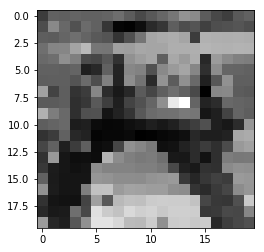

In [59]:
all_images[1]=all_images[1].reshape((20,20))
all_images[11]
all_images[10].shape
plt.imshow(all_images[1],cmap='gray')

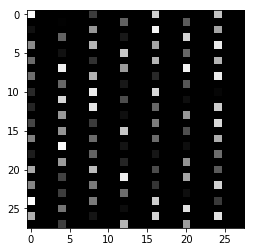

In [43]:
import numpy as np
from PIL import Image 

arr = np.random.randint(255, size=(28*28))
img = Image.fromarray(arr.reshape(28,28), 'L')
